# Optimizing app offers with Starbuck

### Introduction

This data set contains simulated data that mimics customer behavior on the **Starbucks rewards mobile app**. Once every few days, **Starbucks sends out an offer to users of the mobile app**. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Three goals:
1) Identify the people whose purchasing decision are not affected by the offers. <br>
2) Build a classification model to identify the people who most likely to complete the offers. <br>
3) Identify an efficient way to send the offers to customers.

### Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer <BOGO, discount, informational>
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in **days**
* channels (list of strings) <web, email, mobile, and social>

**profile.json**
* age (int) - age of the customer (missing value encoded as 118)
* became_member_on (int) - date (YYYYMMDD) when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F) <M, F, O,or None>
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description <transaction, offer received, offer viewed, and offer completed>
* person (str) - customer id
* time (int) - time in **hours** since start of test. The data begins at time t=0
* value - (dict of strings) - different values depending on event type
  - offer id: not associated with any "transaction";
  - amount: money spent in "transaction";
  - reward: money gained from "offer completed".

## 1. Import libraries and load datasets

In [4]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go # visualization

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


In [5]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2. Overview the three datasets

### (1) portfolio dataset

In [6]:
# portfolio
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

Both bogo offer and discount offer can get reward. 

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


**No missing values** in the portfolio dataset. There are **ten different offers**.

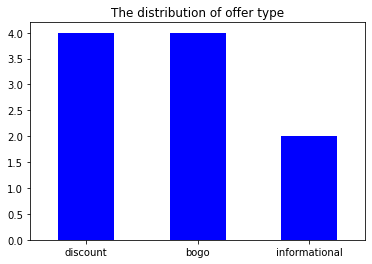

In [8]:
# Distribution of 'offer_type'
portfolio['offer_type'].value_counts().plot(kind='bar', color='b', rot=0, title = 'The distribution of offer type');

Among the ten offers, there are four bogo offers, four discount offers, and two informational offers. <br>
**Four bogo offers**: <br>
(1) buy \\$10 get \\$10, duration 7 days; <br>
(2) buy \\$10 get \\$10, duration 5 days; <br>
(3) buy \\$5 get \\$5, duration 7 days; <br>
(4) buy \\$5 get \\$5, duration 5 days. <br>

**Four discount offers**: <br>
(1) buy \\$20 get \\$5, duration 10 days; <br>
(2) buy \\$7 get \\$3, duration 7 days; <br>
(3) buy \\$10 get \\$2, duration 10 days; <br>
(4) buy \\$10 get \\$2, duration 7 days. <br>

**Two informational offers**:<br>
(1) duration 4 days;<br>
(2) duration 3 days.

**What should do to clean and re-precess the porfolio dataset:** <br>
- Duration units change from days to hours; <br>
- Split the contents of the channels column into several categories, and encode them; <br>
- change column name 'id' to 'offer_id'.

### (2) profile dataset

In [9]:
# profile
profile

gender  age                                id  became_member_on  \
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1          F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3          F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804   
...      ...  ...                               ...               ...   
16995      F   45  6d5f3a774f3d4714ab0c092238f3a1d7          20180604   
16996      M   61  2cb4f97358b841b9a9773a7aa05a9d77          20180713   
16997      M   49  01d26f638c274aa0b965d24cefe3183f          20170126   
16998      F   83  9dc1421481194dcd9400aec7c9ae6366          20160307   
16999      F   62  e4052622e5ba45a8b96b59aba68cf068          20170722   

         income  
0           NaN  
1      112000.0  
2           NaN  
3      100000.0  
4           NaN  
...         ...  
16995   54000.0  
16996   72000.0  
16997   73000.0  
16998   50000.0  
16999   82000.0  

[17000 rows x 5 columns]

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In profile dataset, **no missing and repeated id**. There are 17,000 users. <br>
Some **gender data** and **income data** are **missing** in this dataset. Note: missing age values were encoded as 118.

**What should do to clean and re-precess the profile dataset:** <br>
- Separate the date (year) of the column of "became_member_on"; <br>
- change column name 'id' to 'customer_id'.

In [11]:
# The ratio of each gender
profile["gender"].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [12]:
labels = ['Male','Female','O']
values = profile["gender"].value_counts().values.tolist()

fig = go.Figure(data = [go.Pie(labels = labels, values = values)],layout = go.Layout(title = go.layout.Title(text = 'The distribution of known gender of users')))
fig.show()

### (3) transcript dataset

In [13]:
# transcript
transcript

person           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  time  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4       {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
...                                                  ...   ...  
306529                    {'amount': 1.5899999999999999}   714  
306530                                  {'amount': 9.53}   714  
306531                                  {'amount': 3.61}   714  
306532                    {'amount': 3.5300000000000002}   714  
306533                                  {'amount': 4.05}   714  

[306534 rows x 4 columns]

In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


No missing values in transcript dataset.

In [15]:
# transcript: different events
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [16]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Four different events: offer received, offer viewed, transaction, and offer completed.

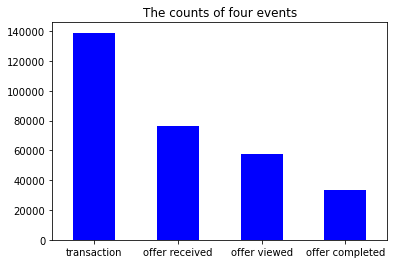

In [17]:
# Distribution of transcript 'event'
transcript['event'].value_counts().plot(kind='bar', color='b', rot=0, title='The counts of four events');

In event column of transcript dataset, there are four events, including transaction, offer receieved, offer viewed, and offer completed.

In [18]:
# the frequency of one customers
transcript['person'].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
                                    ..
3a4e53046c544134bb1e7782248631d1     2
1bfe13d2453c4185a6486c6817e0d568     2
912b9f623b9e4b4eb99b6dc919f09a93     2
fccc9279ba56411f80ffe8ce7e0935cd     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

**What should do to clean and re-precess the transcript dataset:** <br>
- Split the contents in the column of "value"; <br>
- Encode the values in the column of "event"; <br>
- change column name 'person' to 'customer_id'.

## 3. Clean and pre-process datasets 

### (1) Clean the "portfolio" dataset

### <1> Change the unit of the column of "duration" from days to hours

In [19]:
portfolio['duration'] = portfolio['duration'].multiply(24)
portfolio.rename(columns={'duration': 'duration(hrs)'}, inplace = True)

portfolio.head()

reward                      channels  difficulty  duration(hrs)  \
0      10       [email, mobile, social]          10            168   
1      10  [web, email, mobile, social]          10            120   
2       0          [web, email, mobile]           0             96   
3       5          [web, email, mobile]           5            168   
4       5                  [web, email]          20            240   

      offer_type                                id  
0           bogo  ae264e3637204a6fb9bb56bc8210ddfd  
1           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  informational  3f207df678b143eea3cee63160fa8bed  
3           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7

### <2> Change "id" name to "offer_id"

In [20]:
# change id name to offer_id for later merge into whole dataset
portfolio.rename(columns={'id': 'offer_id'}, inplace = True)

portfolio.head()

reward                      channels  difficulty  duration(hrs)  \
0      10       [email, mobile, social]          10            168   
1      10  [web, email, mobile, social]          10            120   
2       0          [web, email, mobile]           0             96   
3       5          [web, email, mobile]           5            168   
4       5                  [web, email]          20            240   

      offer_type                          offer_id  
0           bogo  ae264e3637204a6fb9bb56bc8210ddfd  
1           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  informational  3f207df678b143eea3cee63160fa8bed  
3           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7

### <3> Split "channels" into several categories columns and encode them<br>


In [21]:
# see what the "channels" colume look like
print(type(portfolio['channels']))

portfolio['channels']

<class 'pandas.core.series.Series'>


0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [22]:
# one-hot-encode-from-a-pandas-column-containing-a-list
mlb = MultiLabelBinarizer(sparse_output=True)

portfolio_temp = portfolio.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(portfolio.pop('channels')),
                index=portfolio.index,
                columns=mlb.classes_))

portfolio_temp

reward  difficulty  duration(hrs)     offer_type  \
0      10          10            168           bogo   
1      10          10            120           bogo   
2       0           0             96  informational   
3       5           5            168           bogo   
4       5          20            240       discount   
5       3           7            168       discount   
6       2          10            240       discount   
7       0           0             72  informational   
8       5           5            120           bogo   
9       2          10            168       discount   

                           offer_id  email  mobile  social  web  
0  ae264e3637204a6fb9bb56bc8210ddfd      1       1       1    0  
1  4d5c57ea9a6940dd891ad53e9dbe8da0      1       1       1    1  
2  3f207df678b143eea3cee63160fa8bed      1       1       0    1  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      1       1       0    1  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7      1       0       0    1  
5  2298d6c36e964ae4a3e7e9706d1fb8c2      1       1       1    1  
6  fafdcd668e3743c1bb461111dcafc2a4      1       1       1    1  
7  5a8bc65990b245e5a138643cd4eb9837      1       1       1    0  
8  f19421c1d4aa40978ebb69ca19b0e20d      1       1       1    1  
9  2906b810c7d4411798c6938adc9daaa5      1       1       0    1

In [23]:
# one hot encode using pandas get_dummies
offer_catg = pd.get_dummies(portfolio_temp['offer_type'])
offer_catg

# merge to get transcript_new dataset
portfolio_new = pd.concat([portfolio_temp, offer_catg], axis = 1, sort = False)

portfolio_new

reward  difficulty  duration(hrs)     offer_type  \
0      10          10            168           bogo   
1      10          10            120           bogo   
2       0           0             96  informational   
3       5           5            168           bogo   
4       5          20            240       discount   
5       3           7            168       discount   
6       2          10            240       discount   
7       0           0             72  informational   
8       5           5            120           bogo   
9       2          10            168       discount   

                           offer_id  email  mobile  social  web  bogo  \
0  ae264e3637204a6fb9bb56bc8210ddfd      1       1       1    0     1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0      1       1       1    1     1   
2  3f207df678b143eea3cee63160fa8bed      1       1       0    1     0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      1       1       0    1     1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7      1       0       0    1     0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2      1       1       1    1     0   
6  fafdcd668e3743c1bb461111dcafc2a4      1       1       1    1     0   
7  5a8bc65990b245e5a138643cd4eb9837      1       1       1    0     0   
8  f19421c1d4aa40978ebb69ca19b0e20d      1       1       1    1     1   
9  2906b810c7d4411798c6938adc9daaa5      1       1       0    1     0   

   discount  informational  
0         0              0  
1         0              0  
2         0              1  
3         0              0  
4         1              0  
5         1              0  
6         1              0  
7         0              1  
8         0              0  
9         1              0

### (2) Clean the profile dataset

### <1> Change the column name 'id' to 'customer_id'

In [24]:
# change id name to customer_id for later merge to whole dataset for analysis
profile.rename(columns={'id': 'customer_id'}, inplace = True)

profile

gender  age                       customer_id  became_member_on  \
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1          F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3          F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804   
...      ...  ...                               ...               ...   
16995      F   45  6d5f3a774f3d4714ab0c092238f3a1d7          20180604   
16996      M   61  2cb4f97358b841b9a9773a7aa05a9d77          20180713   
16997      M   49  01d26f638c274aa0b965d24cefe3183f          20170126   
16998      F   83  9dc1421481194dcd9400aec7c9ae6366          20160307   
16999      F   62  e4052622e5ba45a8b96b59aba68cf068          20170722   

         income  
0           NaN  
1      112000.0  
2           NaN  
3      100000.0  
4           NaN  
...         ...  
16995   54000.0  
16996   72000.0  
16997   73000.0  
16998   50000.0  
16999   82000.0  

[17000 rows x 5 columns]

In [25]:
# one hot encode using pandas get_dummies to encode gender
gender_catg = pd.get_dummies(profile['gender'])
gender_catg

# merge to get transcript_new dataset
profile_temp = pd.concat([profile, gender_catg], axis = 1, sort = False)

In [26]:
# change the value of "age" 118 to NaN
profile_temp.loc[profile_temp['age'] == 118, 'age'] = np.nan

profile_temp

gender   age                       customer_id  became_member_on  \
0       None   NaN  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1          F  55.0  0610b486422d4921ae7d2bf64640c50b          20170715   
2       None   NaN  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3          F  75.0  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4       None   NaN  a03223e636434f42ac4c3df47e8bac43          20170804   
...      ...   ...                               ...               ...   
16995      F  45.0  6d5f3a774f3d4714ab0c092238f3a1d7          20180604   
16996      M  61.0  2cb4f97358b841b9a9773a7aa05a9d77          20180713   
16997      M  49.0  01d26f638c274aa0b965d24cefe3183f          20170126   
16998      F  83.0  9dc1421481194dcd9400aec7c9ae6366          20160307   
16999      F  62.0  e4052622e5ba45a8b96b59aba68cf068          20170722   

         income  F  M  O  
0           NaN  0  0  0  
1      112000.0  1  0  0  
2           NaN  0  0  0  
3      100000.0  1  0  0  
4           NaN  0  0  0  
...         ... .. .. ..  
16995   54000.0  1  0  0  
16996   72000.0  0  1  0  
16997   73000.0  0  1  0  
16998   50000.0  1  0  0  
16999   82000.0  1  0  0  

[17000 rows x 8 columns]

### <2> Separate the date (year/month/day) of the column of 'became_member_on'

In [27]:
print(profile_temp['became_member_on'].dtypes)

profile_temp['became_member_on'] = profile_temp['became_member_on'].astype(str)

profile_temp['became_member_year'] = profile_temp['became_member_on'].str[0:4]
profile_temp['became_member_month'] = profile_temp['became_member_on'].str[4:6]
profile_temp['became_member_day'] = profile_temp['became_member_on'].str[6:8]


profile_temp['became_member_on'] = pd.to_numeric(profile_temp['became_member_year']) + 1/12 * pd.to_numeric(profile_temp['became_member_month']) + 1/(12*30) * pd.to_numeric(profile_temp['became_member_day'])

profile_new = profile_temp

profile_new

int64


gender   age                       customer_id  became_member_on  \
0       None   NaN  68be06ca386d4c31939f3a4f0e3dd783       2017.200000   
1          F  55.0  0610b486422d4921ae7d2bf64640c50b       2017.625000   
2       None   NaN  38fe809add3b4fcf9315a9694bb96ff5       2018.616667   
3          F  75.0  78afa995795e4d85b5d9ceeca43f5fef       2017.441667   
4       None   NaN  a03223e636434f42ac4c3df47e8bac43       2017.677778   
...      ...   ...                               ...               ...   
16995      F  45.0  6d5f3a774f3d4714ab0c092238f3a1d7       2018.511111   
16996      M  61.0  2cb4f97358b841b9a9773a7aa05a9d77       2018.619444   
16997      M  49.0  01d26f638c274aa0b965d24cefe3183f       2017.155556   
16998      F  83.0  9dc1421481194dcd9400aec7c9ae6366       2016.269444   
16999      F  62.0  e4052622e5ba45a8b96b59aba68cf068       2017.644444   

         income  F  M  O became_member_year became_member_month  \
0           NaN  0  0  0               2017                  02   
1      112000.0  1  0  0               2017                  07   
2           NaN  0  0  0               2018                  07   
3      100000.0  1  0  0               2017                  05   
4           NaN  0  0  0               2017                  08   
...         ... .. .. ..                ...                 ...   
16995   54000.0  1  0  0               2018                  06   
16996   72000.0  0  1  0               2018                  07   
16997   73000.0  0  1  0               2017                  01   
16998   50000.0  1  0  0               2016                  03   
16999   82000.0  1  0  0               2017                  07   

      became_member_day  
0                    12  
1                    15  
2                    12  
3                    09  
4                    04  
...                 ...  
16995                04  
16996                13  
16997                26  
16998                07  
16999                22  

[17000 rows x 11 columns]

### (3) Clean the transcript dataset

### <1> Change the column name 'person' to 'customer_id'

In [28]:
# change "person" name to customer_id
transcript.rename(columns={'person': 'customer_id'}, inplace = True)

transcript.head()

customer_id           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [29]:
# change "time name" to "time(hrs)"
transcript.rename(columns={'time': 'time(hrs)'}, inplace = True)

In [30]:
# separate the 'value' column to several columns to get dt dataset

dt = [transcript, pd.DataFrame(transcript['value'].tolist())]

dt = pd.concat(dt, axis = 1).drop('value', axis = 1)

dt.head()

customer_id           event  time(hrs)  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received          0   
1  a03223e636434f42ac4c3df47e8bac43  offer received          0   
2  e2127556f4f64592b11af22de27a7932  offer received          0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received          0   
4  68617ca6246f4fbc85e91a2a49552598  offer received          0   

                           offer id  amount offer_id  reward  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN      NaN     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN      NaN     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN      NaN     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN      NaN     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN      NaN     NaN

In [31]:
# merge two offer_id columns to one in dt dataset
fixed_offerID = dt['offer_id'].fillna(dt['offer id'])

# create new dt
dt = dt[['customer_id', 'event', 'time(hrs)','amount', 'reward']].merge(fixed_offerID, left_index=True, right_index=True)

dt

customer_id           event  time(hrs)  amount  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received          0     NaN   
1       a03223e636434f42ac4c3df47e8bac43  offer received          0     NaN   
2       e2127556f4f64592b11af22de27a7932  offer received          0     NaN   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received          0     NaN   
4       68617ca6246f4fbc85e91a2a49552598  offer received          0     NaN   
...                                  ...             ...        ...     ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction        714    1.59   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction        714    9.53   
306531  a00058cf10334a308c68e7631c529907     transaction        714    3.61   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction        714    3.53   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction        714    4.05   

        reward                          offer_id  
0          NaN  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1          NaN  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2          NaN  2906b810c7d4411798c6938adc9daaa5  
3          NaN  fafdcd668e3743c1bb461111dcafc2a4  
4          NaN  4d5c57ea9a6940dd891ad53e9dbe8da0  
...        ...                               ...  
306529     NaN                               NaN  
306530     NaN                               NaN  
306531     NaN                               NaN  
306532     NaN                               NaN  
306533     NaN                               NaN  

[306534 rows x 6 columns]

In [32]:
# one hot encode using pandas get_dummies
events_catg = pd.get_dummies(transcript['event'])
events_catg.head()

offer completed  offer received  offer viewed  transaction
0                0               1             0            0
1                0               1             0            0
2                0               1             0            0
3                0               1             0            0
4                0               1             0            0

In [33]:
# merge to get transcript_new dataset
transcript_new = pd.concat([dt, events_catg], axis = 1, sort = False)

# remove 'event' column for transcript dataset
transcript_new = transcript_new.drop('event', axis=1) 
transcript_new.head()

customer_id  time(hrs)  amount  reward  \
0  78afa995795e4d85b5d9ceeca43f5fef          0     NaN     NaN   
1  a03223e636434f42ac4c3df47e8bac43          0     NaN     NaN   
2  e2127556f4f64592b11af22de27a7932          0     NaN     NaN   
3  8ec6ce2a7e7949b1bf142def7d0e0586          0     NaN     NaN   
4  68617ca6246f4fbc85e91a2a49552598          0     NaN     NaN   

                           offer_id  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7                0               1   
2  2906b810c7d4411798c6938adc9daaa5                0               1   
3  fafdcd668e3743c1bb461111dcafc2a4                0               1   
4  4d5c57ea9a6940dd891ad53e9dbe8da0                0               1   

   offer viewed  transaction  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             0            0

In [34]:
transcript_new

customer_id  time(hrs)  amount  reward  \
0       78afa995795e4d85b5d9ceeca43f5fef          0     NaN     NaN   
1       a03223e636434f42ac4c3df47e8bac43          0     NaN     NaN   
2       e2127556f4f64592b11af22de27a7932          0     NaN     NaN   
3       8ec6ce2a7e7949b1bf142def7d0e0586          0     NaN     NaN   
4       68617ca6246f4fbc85e91a2a49552598          0     NaN     NaN   
...                                  ...        ...     ...     ...   
306529  b3a1272bc9904337b331bf348c3e8c17        714    1.59     NaN   
306530  68213b08d99a4ae1b0dcb72aebd9aa35        714    9.53     NaN   
306531  a00058cf10334a308c68e7631c529907        714    3.61     NaN   
306532  76ddbd6576844afe811f1a3c0fbb5bec        714    3.53     NaN   
306533  c02b10e8752c4d8e9b73f918558531f7        714    4.05     NaN   

                                offer_id  offer completed  offer received  \
0       9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1       0b1e1539f2cc45b7b9fa7c272da2e1d7                0               1   
2       2906b810c7d4411798c6938adc9daaa5                0               1   
3       fafdcd668e3743c1bb461111dcafc2a4                0               1   
4       4d5c57ea9a6940dd891ad53e9dbe8da0                0               1   
...                                  ...              ...             ...   
306529                               NaN                0               0   
306530                               NaN                0               0   
306531                               NaN                0               0   
306532                               NaN                0               0   
306533                               NaN                0               0   

        offer viewed  transaction  
0                  0            0  
1                  0            0  
2                  0            0  
3                  0            0  
4                  0            0  
...              ...          ...  
306529             0            1  
306530             0            1  
306531             0            1  
306532             0            1  
306533             0            1  

[306534 rows x 9 columns]

## 4. Merge the processed datasets for analysis

In [35]:
# merge three datasets into one <data_all>
data = pd.merge(transcript_new, profile_new, on = ['customer_id']) 

data

customer_id  time(hrs)  amount  reward  \
0       78afa995795e4d85b5d9ceeca43f5fef          0     NaN     NaN   
1       78afa995795e4d85b5d9ceeca43f5fef          6     NaN     NaN   
2       78afa995795e4d85b5d9ceeca43f5fef        132   19.89     NaN   
3       78afa995795e4d85b5d9ceeca43f5fef        132     NaN     5.0   
4       78afa995795e4d85b5d9ceeca43f5fef        144   17.78     NaN   
...                                  ...        ...     ...     ...   
306529  912b9f623b9e4b4eb99b6dc919f09a93        576     NaN     NaN   
306530  912b9f623b9e4b4eb99b6dc919f09a93        594     NaN     NaN   
306531  3045af4e98794a04a5542d3eac939b1f        576     NaN     NaN   
306532  3045af4e98794a04a5542d3eac939b1f        576     NaN     NaN   
306533  da7a7c0dcfcb41a8acc7864a53cf60fb        582    0.35     NaN   

                                offer_id  offer completed  offer received  \
0       9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1       9b98b8c7a33c4b65b9aebfe6a799e6d9                0               0   
2                                    NaN                0               0   
3       9b98b8c7a33c4b65b9aebfe6a799e6d9                1               0   
4                                    NaN                0               0   
...                                  ...              ...             ...   
306529  4d5c57ea9a6940dd891ad53e9dbe8da0                0               1   
306530  4d5c57ea9a6940dd891ad53e9dbe8da0                0               0   
306531  4d5c57ea9a6940dd891ad53e9dbe8da0                0               1   
306532  4d5c57ea9a6940dd891ad53e9dbe8da0                0               0   
306533                               NaN                0               0   

        offer viewed  transaction gender   age  became_member_on    income  F  \
0                  0            0      F  75.0       2017.441667  100000.0  1   
1                  1            0      F  75.0       2017.441667  100000.0  1   
2                  0            1      F  75.0       2017.441667  100000.0  1   
3                  0            0      F  75.0       2017.441667  100000.0  1   
4                  0            1      F  75.0       2017.441667  100000.0  1   
...              ...          ...    ...   ...               ...       ... ..   
306529             0            0   None   NaN       2017.822222       NaN  0   
306530             1            0   None   NaN       2017.822222       NaN  0   
306531             0            0      F  58.0       2016.888889   78000.0  1   
306532             1            0      F  58.0       2016.888889   78000.0  1   
306533             0            1   None   NaN       2017.669444       NaN  0   

        M  O became_member_year became_member_month became_member_day  
0       0  0               2017                  05                09  
1       0  0               2017                  05                09  
2       0  0               2017                  05                09  
3       0  0               2017                  05                09  
4       0  0               2017                  05                09  
...    .. ..                ...                 ...               ...  
306529  0  0               2017                  09                26  
306530  0  0               2017                  09                26  
306531  0  0               2016                  10                20  
306532  0  0               2016                  10                20  
306533  0  0               2017                  08                01  

[306534 rows x 19 columns]

In [36]:
portfolio_new.rename(columns={'reward': 'rewardy'}, inplace = True)

data_all = data.merge(portfolio_new, how = 'left', on = 'offer_id')

data_all

customer_id  time(hrs)  amount  reward  \
0       78afa995795e4d85b5d9ceeca43f5fef          0     NaN     NaN   
1       78afa995795e4d85b5d9ceeca43f5fef          6     NaN     NaN   
2       78afa995795e4d85b5d9ceeca43f5fef        132   19.89     NaN   
3       78afa995795e4d85b5d9ceeca43f5fef        132     NaN     5.0   
4       78afa995795e4d85b5d9ceeca43f5fef        144   17.78     NaN   
...                                  ...        ...     ...     ...   
306529  912b9f623b9e4b4eb99b6dc919f09a93        576     NaN     NaN   
306530  912b9f623b9e4b4eb99b6dc919f09a93        594     NaN     NaN   
306531  3045af4e98794a04a5542d3eac939b1f        576     NaN     NaN   
306532  3045af4e98794a04a5542d3eac939b1f        576     NaN     NaN   
306533  da7a7c0dcfcb41a8acc7864a53cf60fb        582    0.35     NaN   

                                offer_id  offer completed  offer received  \
0       9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1       9b98b8c7a33c4b65b9aebfe6a799e6d9                0               0   
2                                    NaN                0               0   
3       9b98b8c7a33c4b65b9aebfe6a799e6d9                1               0   
4                                    NaN                0               0   
...                                  ...              ...             ...   
306529  4d5c57ea9a6940dd891ad53e9dbe8da0                0               1   
306530  4d5c57ea9a6940dd891ad53e9dbe8da0                0               0   
306531  4d5c57ea9a6940dd891ad53e9dbe8da0                0               1   
306532  4d5c57ea9a6940dd891ad53e9dbe8da0                0               0   
306533                               NaN                0               0   

        offer viewed  transaction gender  ...  difficulty  duration(hrs)  \
0                  0            0      F  ...         5.0          168.0   
1                  1            0      F  ...         5.0          168.0   
2                  0            1      F  ...         NaN            NaN   
3                  0            0      F  ...         5.0          168.0   
4                  0            1      F  ...         NaN            NaN   
...              ...          ...    ...  ...         ...            ...   
306529             0            0   None  ...        10.0          120.0   
306530             1            0   None  ...        10.0          120.0   
306531             0            0      F  ...        10.0          120.0   
306532             1            0      F  ...        10.0          120.0   
306533             0            1   None  ...         NaN            NaN   

        offer_type  email  mobile  social  web bogo discount  informational  
0             bogo    1.0     1.0     0.0  1.0  1.0      0.0            0.0  
1             bogo    1.0     1.0     0.0  1.0  1.0      0.0            0.0  
2              NaN    NaN     NaN     NaN  NaN  NaN      NaN            NaN  
3             bogo    1.0     1.0     0.0  1.0  1.0      0.0            0.0  
4              NaN    NaN     NaN     NaN  NaN  NaN      NaN            NaN  
...            ...    ...     ...     ...  ...  ...      ...            ...  
306529        bogo    1.0     1.0     1.0  1.0  1.0      0.0            0.0  
306530        bogo    1.0     1.0     1.0  1.0  1.0      0.0            0.0  
306531        bogo    1.0     1.0     1.0  1.0  1.0      0.0            0.0  
306532        bogo    1.0     1.0     1.0  1.0  1.0      0.0            0.0  
306533         NaN    NaN     NaN     NaN  NaN  NaN      NaN            NaN  

[306534 rows x 30 columns]

# Visualization of the processed data

C:\Users\zzyan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 1.0, 'The counts of offer received of all users')]

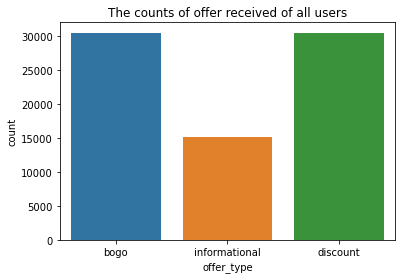

In [37]:
# offer types
#<1> The counts of offer received
received_offer_count = data_all[data_all['offer received'] == 1]
sns.countplot(received_offer_count['offer_type']).set(title='The counts of offer received of all users')

[Text(0.5, 1.0, 'The count of recieved offer in different gender')]

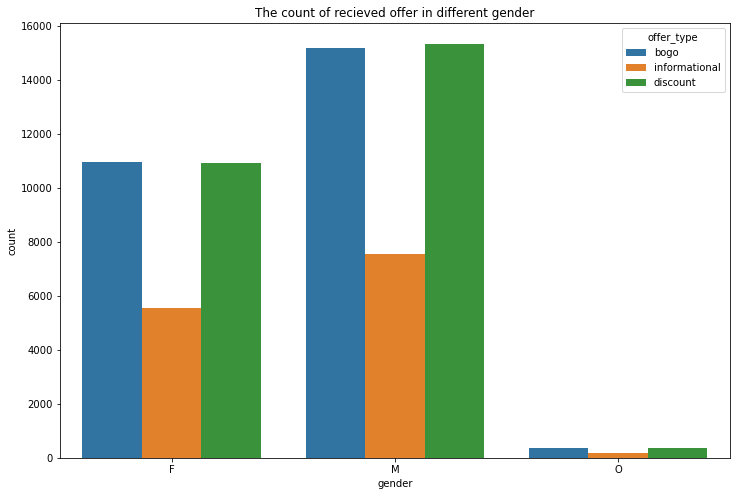

In [38]:
plt.figure(figsize=(12,8))
sns.countplot(x="gender", hue="offer_type",data=received_offer_count).set(title='The count of recieved offer in different gender')

C:\Users\zzyan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 1.0, 'The counts of offer viewed of all users')]

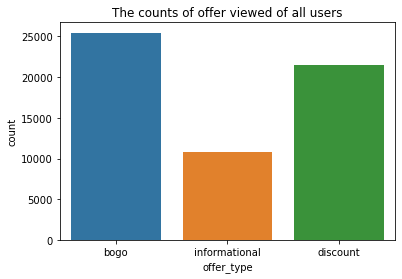

In [39]:
#<2> The counts of offer viewed
viewed_offer_count = data_all[data_all['offer viewed'] == 1]
sns.countplot(viewed_offer_count['offer_type']).set(title='The counts of offer viewed of all users')

[Text(0.5, 1.0, 'The count of viewed offer in different gender')]

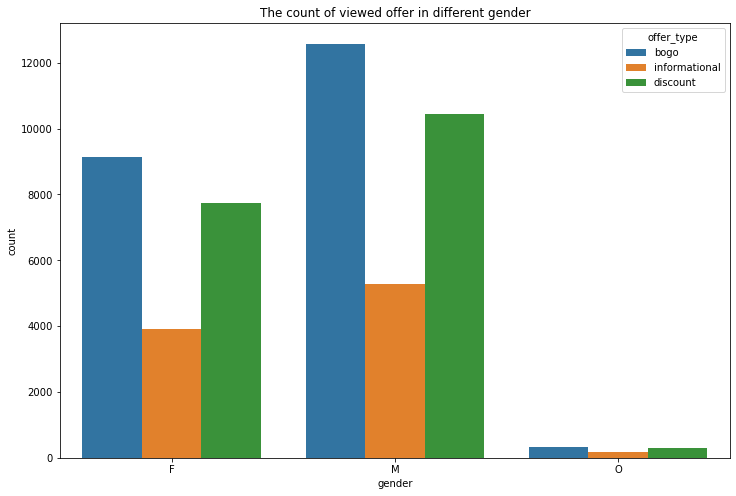

In [40]:
plt.figure(figsize=(12,8))
sns.countplot(x="gender", hue="offer_type",data=viewed_offer_count).set(title='The count of viewed offer in different gender')

C:\Users\zzyan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 1.0, 'The counts of offer completed of all users')]

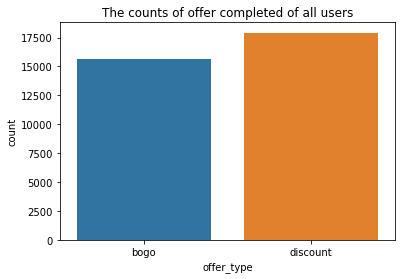

In [41]:
#<3> The counts of offer completed
completed_offer_count = data_all[data_all['offer completed'] == 1]
sns.countplot(completed_offer_count['offer_type']).set(title='The counts of offer completed of all users')

[Text(0.5, 1.0, 'The count of completed offer in different gender')]

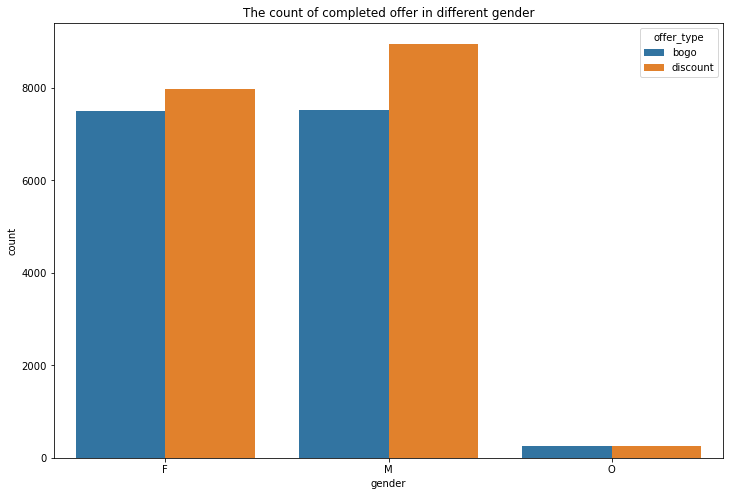

In [42]:
plt.figure(figsize=(12,8))
sns.countplot(x="gender", hue="offer_type",data=completed_offer_count).set(title='The count of completed offer in different gender')

# Transcript summary for all users

In [43]:
user_data0 = transcript_new.groupby(['customer_id'])[['amount','reward','transaction','offer received','offer viewed','offer completed']].sum()

temp1 = data_all[data_all['offer received'] == 1]
user_data1 = temp1.groupby(['customer_id'])[['bogo','informational','discount']].sum()

user_data1.rename(columns={'bogo': 'bogo_received_count'}, inplace = True)
user_data1.rename(columns={'informational': 'info_received_count'}, inplace = True)
user_data1.rename(columns={'discount': 'discount_received_count'}, inplace = True)

user_data_temp1 = user_data0.merge(user_data1, how = 'left', on = 'customer_id')



temp2 = data_all[data_all['offer completed'] == 1]
user_data2 = temp2.groupby(['customer_id'])[['bogo','discount']].sum()

user_data2.rename(columns={'bogo': 'bogo_completed_count'}, inplace = True)
user_data2.rename(columns={'discount': 'discount_completed_count'}, inplace = True)

user_data_temp2 = user_data_temp1.merge(user_data2, how = 'left', on = 'customer_id')



temp3 = data_all[data_all['offer viewed'] == 1]
user_data3 = temp3.groupby(['customer_id'])[['informational']].sum()

user_data3.rename(columns={'informational': 'info_viewed_count'}, inplace = True)

user_data_temp3 = user_data_temp2.merge(user_data3, how = 'left', on = 'customer_id')



profile_select = profile_new[['customer_id','gender','age','became_member_on','income','F','M','O']]
user_data = pd.merge(user_data_temp3, profile_select, on = ['customer_id']) 

user_data.rename(columns={'amount': 'amount_sum'}, inplace = True)
user_data.rename(columns={'transaction': 'transaction_count'}, inplace = True)
user_data.rename(columns={'offer received': 'offer received_count'}, inplace = True)
user_data.rename(columns={'offer viewed': 'offer viewed_count'}, inplace = True)
user_data.rename(columns={'offer completed': 'offer completed_count'}, inplace = True)


user_data['bogo_responseRate'] = user_data['bogo_completed_count']/user_data['bogo_received_count']
user_data['info_responseRate'] = user_data['info_viewed_count']/user_data['info_received_count']
user_data['discount_responseRate'] = user_data['discount_completed_count']/user_data['discount_received_count']
user_data['amount_per'] = user_data['amount_sum']/user_data['transaction_count']
# fill zero if NaN
user_data['bogo_responseRate'] = user_data['bogo_responseRate'].fillna(0)
user_data['info_responseRate'] = user_data['info_responseRate'].fillna(0)
user_data['discount_responseRate'] = user_data['discount_responseRate'].fillna(0)


user_data


customer_id  amount_sum  reward  \
0      0009655768c64bdeb2e877511632db8f      127.60     9.0   
1      00116118485d4dfda04fdbaba9a87b5c        4.09     0.0   
2      0011e0d4e6b944f998e987f904e8c1e5       79.46    13.0   
3      0020c2b971eb4e9188eac86d93036a77      196.86    14.0   
4      0020ccbbb6d84e358d3414a3ff76cffd      154.05    13.0   
...                                 ...         ...     ...   
16995  fff3ba4757bd42088c044ca26d73817a      580.98     9.0   
16996  fff7576017104bcc8677a8d63322b5e1       29.94     9.0   
16997  fff8957ea8b240a6b5e634b6ee8eafcf       12.15     0.0   
16998  fffad4f4828548d1b5583907f2e9906b       88.83    15.0   
16999  ffff82501cea40309d5fdd7edcca4a07      226.07    18.0   

       transaction_count  offer received_count  offer viewed_count  \
0                      8                     5                   4   
1                      3                     2                   2   
2                      5                     5                   5   
3                      8                     5                   3   
4                     12                     4                   4   
...                  ...                   ...                 ...   
16995                 11                     6                   3   
16996                  6                     5                   4   
16997                  5                     3                   2   
16998                 12                     4                   4   
16999                 15                     6                   6   

       offer completed_count  bogo_received_count  info_received_count  \
0                          3                  1.0                  2.0   
1                          0                  2.0                  0.0   
2                          3                  1.0                  2.0   
3                          3                  2.0                  1.0   
4                          3                  2.0                  1.0   
...                      ...                  ...                  ...   
16995                      3                  1.0                  2.0   
16996                      3                  3.0                  0.0   
16997                      0                  1.0                  1.0   
16998                      3                  3.0                  1.0   
16999                      6                  1.0                  0.0   

       discount_received_count  ...   age  became_member_on   income  F  M  O  \
0                          2.0  ...  33.0       2017.391667  72000.0  0  1  0   
1                          0.0  ...   NaN       2018.402778      NaN  0  0  0   
2                          2.0  ...  40.0       2018.108333  57000.0  0  0  1   
3                          2.0  ...  59.0       2016.261111  90000.0  1  0  0   
4                          1.0  ...  24.0       2016.947222  60000.0  1  0  0   
...                        ...  ...   ...               ...      ... .. .. ..   
16995                      3.0  ...  69.0       2015.805556  83000.0  1  0  0   
16996                      2.0  ...  71.0       2017.919444  73000.0  0  1  0   
16997                      1.0  ...  71.0       2018.216667  56000.0  0  1  0   
16998                      0.0  ...  34.0       2017.147222  34000.0  0  1  0   
16999                      5.0  ...  45.0       2016.986111  62000.0  1  0  0   

       bogo_responseRate  info_responseRate  discount_responseRate  amount_per  
0               1.000000                1.0               1.000000   15.950000  
1               0.000000                0.0               0.000000    1.363333  
2               1.000000                1.0               1.000000   15.892000  
3               0.500000                1.0               1.000000   24.607500  
4               1.000000                1.0               1.000000   12.837500  
...                  ...                ...                    ...         ...  
1

In [44]:
# current profit
profit = user_data['amount_sum'].sum() - user_data['reward'].sum()

profit  

1610775.9700000002

<Figure size 1080x432 with 0 Axes>

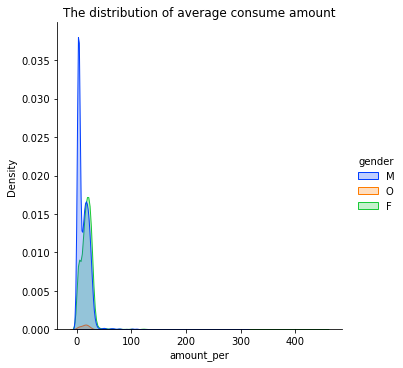

In [45]:
# The distribution of average consume amount from users
plt.figure(figsize=(15, 6))
sns.displot(data = user_data, x='amount_per', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of average consume amount')
plt.show()

### People who buy without offer

In [46]:
# people who buy without offer
buy_anyway = user_data[(user_data.amount_sum > 0) & (user_data['offer completed_count'] == 0)]
buy_anyway

customer_id  amount_sum  reward  \
1      00116118485d4dfda04fdbaba9a87b5c        4.09     0.0   
11     0063def0f9c14bc4805322a488839b32        7.21     0.0   
16     00857b24b13f4fe0ad17b605f00357f5        6.26     0.0   
17     008d7088107b468893889da0ede0df5c       16.18     0.0   
19     0092a132ead946ceb30d11a1ed513d20        2.54     0.0   
...                                 ...         ...     ...   
16982  ffc77312ccda49fca19506f1cdf44923       33.77     0.0   
16990  ffecb1f8543f4bf7bade023de366d6bf        9.97     0.0   
16992  ffede3b700ac41d6a266fa1ba74b4f16       21.35     0.0   
16993  fff0f0aac6c547b9b263080f09a5586a      116.90     0.0   
16997  fff8957ea8b240a6b5e634b6ee8eafcf       12.15     0.0   

       transaction_count  offer received_count  offer viewed_count  \
1                      3                     2                   2   
11                     3                     5                   5   
16                     4                     5                   3   
17                     7                     6                   5   
19                     3                     6                   6   
...                  ...                   ...                 ...   
16982                  9                     5                   2   
16990                  3                     5                   5   
16992                 11                     4                   3   
16993                  6                     3                   3   
16997                  5                     3                   2   

       offer completed_count  bogo_received_count  info_received_count  \
1                          0                  2.0                  0.0   
11                         0                  2.0                  1.0   
16                         0                  4.0                  0.0   
17                         0                  3.0                  2.0   
19                         0                  3.0                  1.0   
...                      ...                  ...                  ...   
16982                      0                  3.0                  1.0   
16990                      0                  1.0                  1.0   
16992                      0                  2.0                  0.0   
16993                      0                  1.0                  2.0   
16997                      0                  1.0                  1.0   

       discount_received_count  ...   age  became_member_on   income  F  M  O  \
1                          0.0  ...   NaN       2018.402778      NaN  0  0  0   
11                         2.0  ...   NaN       2018.541667      NaN  0  0  0   
16                         1.0  ...  71.0       2017.897222  41000.0  0  1  0   
17                         1.0  ...  24.0       2017.777778  42000.0  0  1  0   
19                         2.0  ...   NaN       2018.422222      NaN  0  0  0   
...                        ...  ...   ...               ...      ... .. .. ..   
16982                      1.0  ...  37.0       2017.302778  70000.0  0  1  0   
16990                      3.0  ...   NaN       2017.908333      NaN  0  0  0   
16992                      2.0  ...   NaN       2018.594444      NaN  0  0  0   
16993                      0.0  ...  67.0       2017.541667  80000.0  0  1  0   
16997                      1.0  ...  71.0       2018.216667  56000.0  0  1  0   

       bogo_responseRate  info_responseRate  discount_responseRate  amount_per  
1                    0.0                0.0                    0.0    1.363333  
11                   0.0                1.0                    0.0    2.403333  
16                   0.0                0.0                    0.0    1.565000  
17                   0.0                1.0                    0.0    2.311429  
19                   0.0                1.0                    0.0    0.846667  
...                  ...                ...                    ...         ...  
1

<Figure size 1080x432 with 0 Axes>

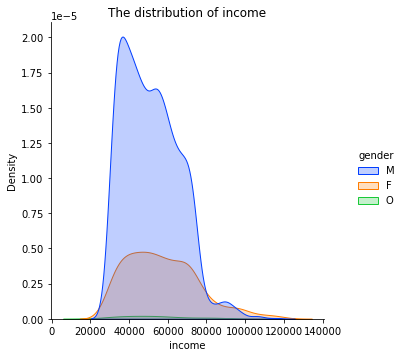

In [47]:
# The distribution of income 
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = buy_anyway, x='income', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of income')
plt.show()

<Figure size 1080x432 with 0 Axes>

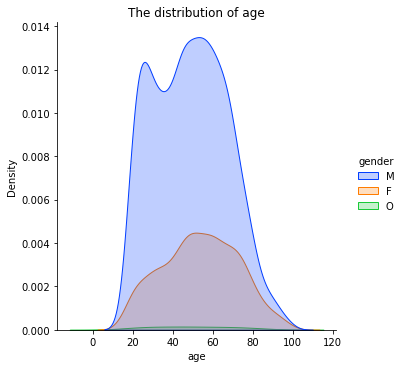

In [48]:
# The distribution of age 
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = buy_anyway, x='age', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of age')
plt.show()

<Figure size 1080x432 with 0 Axes>

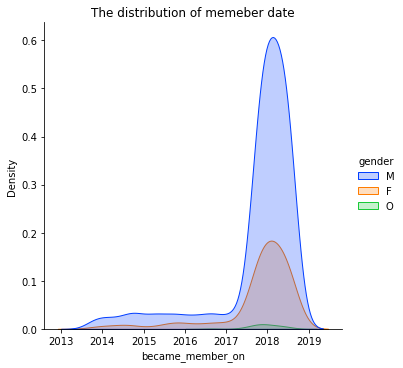

In [49]:
# The distribution of member_date
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = buy_anyway, x='became_member_on', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of memeber date')
plt.show()

### People who will not buy even receiving offers

In [50]:
# people who will not buy even receive offer
never_buy = user_data[(user_data.amount_sum == 0) & (user_data['offer received_count'] > 0)]
never_buy

customer_id  amount_sum  reward  \
106    01d7da27b8934ba1b3602a0153e4415f         0.0     0.0   
192    031387fa9cfd47e88f4e4b4b4cb71925         0.0     0.0   
271    043b6b6be98c412d901f7f376e0548d0         0.0     0.0   
274    044a7e5bbe7f4c66a898ad1dc4bc0049         0.0     0.0   
284    04837bcb97e241769a747cd71c50fe2f         0.0     0.0   
...                                 ...         ...     ...   
16966  ff8bb9517a1e4ef18b63eb9f2ba67d9e         0.0     0.0   
16967  ff8bee9ba3754ac687d9af685b2981b7         0.0     0.0   
16981  ffc6c9fbe34b4578911dcdf6745b4c74         0.0     0.0   
16985  ffd810f301ad42d6bfe98c4ba6ee4125         0.0     0.0   
16991  ffed75d3abc64b488982f50ed12878b5         0.0     0.0   

       transaction_count  offer received_count  offer viewed_count  \
106                    0                     5                   4   
192                    0                     5                   5   
271                    0                     4                   4   
274                    0                     5                   4   
284                    0                     5                   2   
...                  ...                   ...                 ...   
16966                  0                     5                   5   
16967                  0                     3                   3   
16981                  0                     3                   2   
16985                  0                     3                   3   
16991                  0                     2                   2   

       offer completed_count  bogo_received_count  info_received_count  \
106                        0                  1.0                  2.0   
192                        0                  0.0                  1.0   
271                        0                  1.0                  0.0   
274                        0                  1.0                  0.0   
284                        0                  1.0                  2.0   
...                      ...                  ...                  ...   
16966                      0                  2.0                  1.0   
16967                      0                  0.0                  0.0   
16981                      0                  1.0                  0.0   
16985                      0                  1.0                  1.0   
16991                      0                  2.0                  0.0   

       discount_received_count  ...   age  became_member_on   income  F  M  O  \
106                        2.0  ...  44.0       2018.283333  76000.0  1  0  0   
192                        4.0  ...  41.0       2017.811111  83000.0  0  1  0   
271                        3.0  ...  73.0       2017.847222  77000.0  0  1  0   
274                        4.0  ...  65.0       2018.394444  52000.0  0  1  0   
284                        2.0  ...  71.0       2018.241667  45000.0  0  1  0   
...                        ...  ...   ...               ...      ... .. .. ..   
16966                      2.0  ...  54.0       2018.133333  85000.0  1  0  0   
16967                      3.0  ...  64.0       2018.502778  72000.0  0  1  0   
16981                      2.0  ...  62.0       2018.361111  57000.0  1  0  0   
16985                      1.0  ...  65.0       2018.208333  52000.0  0  1  0   
16991                      0.0  ...  20.0       2018.291667  44000.0  0  1  0   

       bogo_responseRate  info_responseRate  discount_responseRate  amount_per  
106                  0.0                1.0                    0.0         NaN  
192                  0.0                1.0                    0.0         NaN  
271                  0.0                0.0                    0.0         NaN  
274                  0.0                0.0                    0.0         NaN  
284                  0.0                0.5                    0.0         NaN  
...                  ...                ...                    ...         ...  
1

<Figure size 1080x432 with 0 Axes>

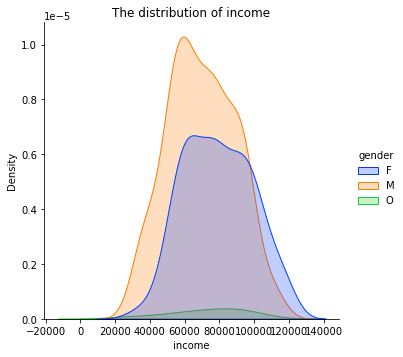

In [51]:
# The distribution of income 
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = never_buy, x='income', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of income')
plt.show()

<Figure size 1080x432 with 0 Axes>

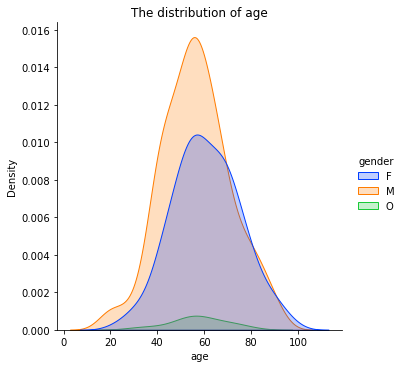

In [52]:
# The distribution of age 
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = never_buy, x='age', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of age')
plt.show()

<Figure size 1080x432 with 0 Axes>

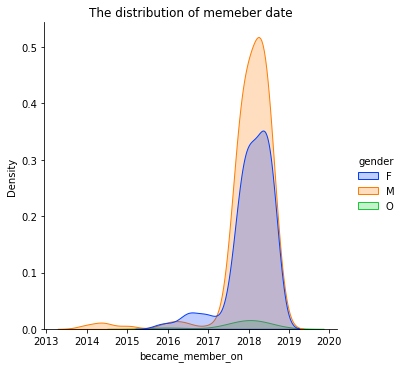

In [53]:
# The distribution of member_date
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = never_buy, x='became_member_on', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of memeber date')
plt.show()

### People who buy with offers

In [54]:
# eg. DF=DF1[~DF1.isin(DF2)].dropna(how = 'all')  # To get dataframe with all records which are in DF1 but not in DF2
buy_offer_temp = user_data[~user_data.isin(buy_anyway)].dropna(how = 'all')
buy_offer = buy_offer_temp[~buy_offer_temp.isin(never_buy)].dropna(how = 'all')

buy_offer

customer_id  amount_sum  reward  \
0      0009655768c64bdeb2e877511632db8f      127.60     9.0   
2      0011e0d4e6b944f998e987f904e8c1e5       79.46    13.0   
3      0020c2b971eb4e9188eac86d93036a77      196.86    14.0   
4      0020ccbbb6d84e358d3414a3ff76cffd      154.05    13.0   
5      003d66b6608740288d6cc97a6903f4f0       48.34     9.0   
...                                 ...         ...     ...   
16994  fff29fb549084123bd046dbc5ceb4faa      291.47    47.0   
16995  fff3ba4757bd42088c044ca26d73817a      580.98     9.0   
16996  fff7576017104bcc8677a8d63322b5e1       29.94     9.0   
16998  fffad4f4828548d1b5583907f2e9906b       88.83    15.0   
16999  ffff82501cea40309d5fdd7edcca4a07      226.07    18.0   

       transaction_count  offer received_count  offer viewed_count  \
0                    8.0                   5.0                 4.0   
2                    5.0                   5.0                 5.0   
3                    8.0                   5.0                 3.0   
4                   12.0                   4.0                 4.0   
5                   18.0                   5.0                 4.0   
...                  ...                   ...                 ...   
16994               11.0                   6.0                 5.0   
16995               11.0                   6.0                 3.0   
16996                6.0                   5.0                 4.0   
16998               12.0                   4.0                 4.0   
16999               15.0                   6.0                 6.0   

       offer completed_count  bogo_received_count  info_received_count  \
0                        3.0                  1.0                  2.0   
2                        3.0                  1.0                  2.0   
3                        3.0                  2.0                  1.0   
4                        3.0                  2.0                  1.0   
5                        3.0                  0.0                  2.0   
...                      ...                  ...                  ...   
16994                    6.0                  5.0                  0.0   
16995                    3.0                  1.0                  2.0   
16996                    3.0                  3.0                  0.0   
16998                    3.0                  3.0                  1.0   
16999                    6.0                  1.0                  0.0   

       discount_received_count  ...   age  became_member_on   income    F  \
0                          2.0  ...  33.0       2017.391667  72000.0  0.0   
2                          2.0  ...  40.0       2018.108333  57000.0  0.0   
3                          2.0  ...  59.0       2016.261111  90000.0  1.0   
4                          1.0  ...  24.0       2016.947222  60000.0  1.0   
5                          3.0  ...  26.0       2017.558333  73000.0  1.0   
...                        ...  ...   ...               ...      ...  ...   
16994                      1.0  ...  59.0       2017.752778  93000.0  1.0   
16995                      3.0  ...  69.0       2015.805556  83000.0  1.0   
16996                      2.0  ...  71.0       2017.919444  73000.0  0.0   
16998                      0.0  ...  34.0       2017.147222  34000.0  0.0   
16999                      5.0  ...  45.0       2016.986111  62000.0  1.0   

         M    O  bogo_responseRate  info_responseRate  discount_responseRate  \
0      1.0  0.0           1.000000                1.0               1.000000   
2      0.0  1.0           1.000000                1.0               1.000000   
3      0.0  0.0           0.500000                1.0               1.000000   
4      0.0  0.0           1.000000                1.0               1.000000   
5      0.0  0.0           0.000000                1.0               1.000000   
...    ...  ...                ...                ...                    ...   
16994  0.0  0.0           1.000000                0.0   

<Figure size 1080x432 with 0 Axes>

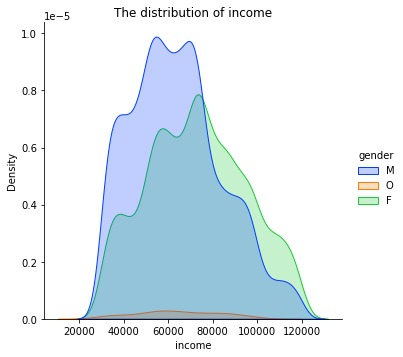

In [55]:
# The distribution of income 
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = buy_offer, x='income', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of income')
plt.show()

<Figure size 1080x432 with 0 Axes>

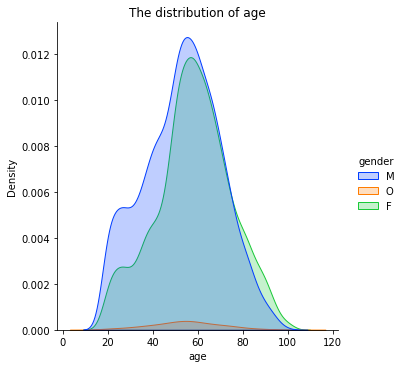

In [56]:
# The distribution of age 
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = buy_offer, x='age', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of age')
plt.show()

<Figure size 1080x432 with 0 Axes>

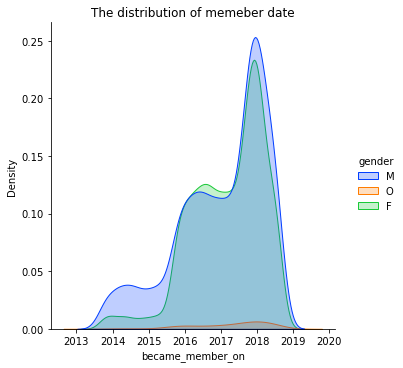

In [57]:
# The distribution of member_date
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = buy_offer, x='became_member_on', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of memeber date')
plt.show()

<Figure size 1080x432 with 0 Axes>

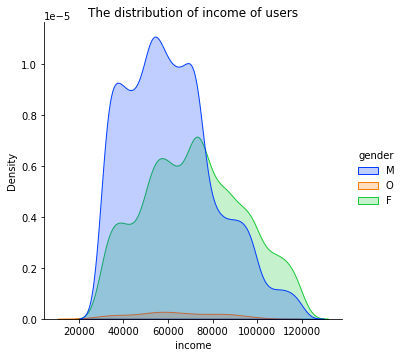

In [58]:
# income
#<1> The distribution of income of known users
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.income, kde = True).set(title='The distribution of income of users')
sns.displot(data = user_data, x='income', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of income of users')
plt.show()

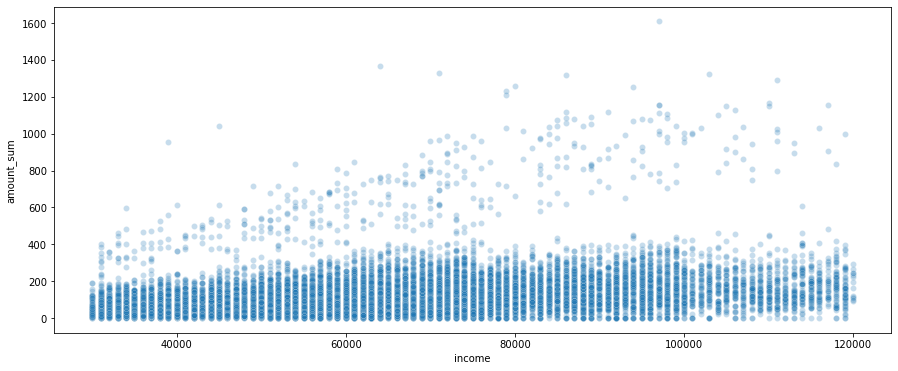

In [59]:
#<2> amount vs income
plt.figure(figsize=(15, 6))
# sns.lmplot(x='income', y='amount', data=user_data)
sns.scatterplot(x='income', y='amount_sum', data=user_data, alpha=.25)
plt.show()

<Figure size 1080x432 with 0 Axes>

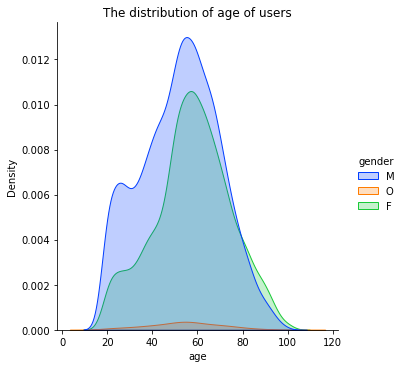

In [60]:
# age
#<1> The distribution of age of known users
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.age, kde = True).set(title='The distribution of age of users')
sns.displot(data = user_data, x='age', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of age of users')
plt.show()

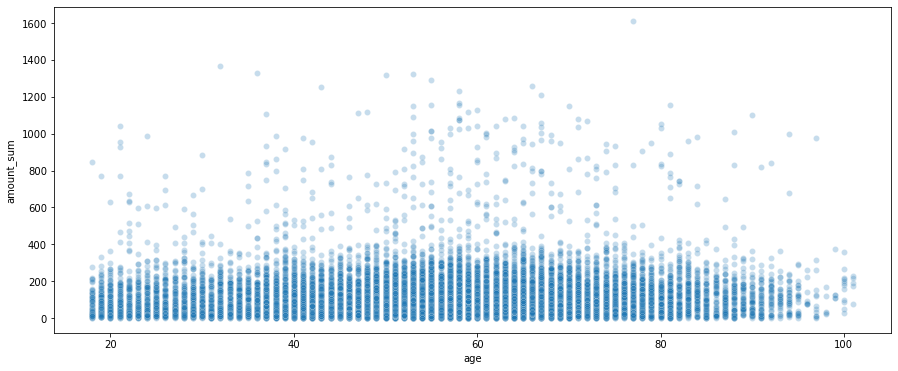

In [61]:
# amount vs age
plt.figure(figsize=(15, 6))
sns.scatterplot(x='age', y='amount_sum', data=user_data, alpha=.25)
plt.show()

<Figure size 1080x432 with 0 Axes>

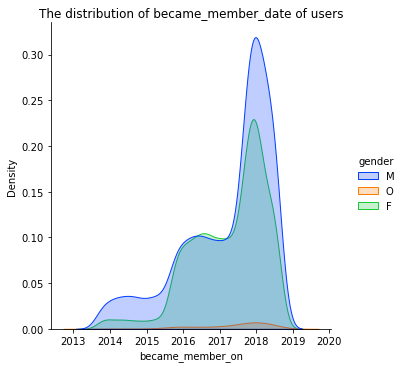

In [62]:
# member date
#<1> The distribution of memberDate of known users
plt.figure(figsize=(15, 6))
# sns.distplot(user_data.age, kde = True).set(title='The distribution of age of users')
sns.displot(data = user_data, x='became_member_on', hue='gender', kind='kde', fill=True, palette=sns.color_palette('bright')[:3]).set(title='The distribution of became_member_date of users')
plt.show()

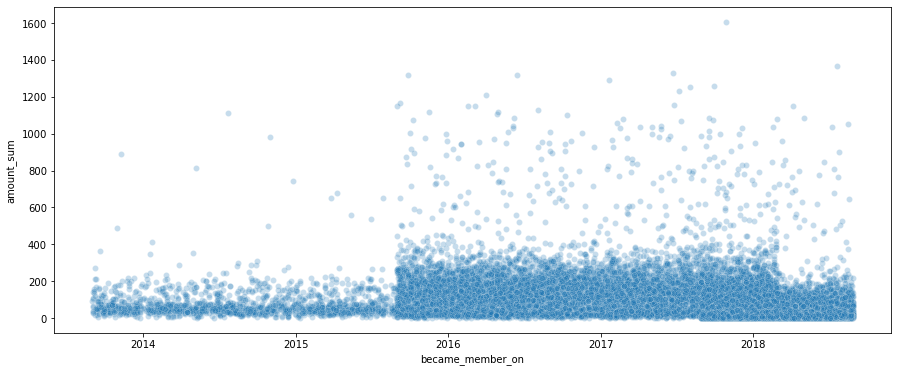

In [63]:
# amount vs member date
plt.figure(figsize=(15, 6))
sns.scatterplot(x='became_member_on', y='amount_sum', data=user_data, alpha=.25)
plt.show()

## The correlation matrix among all the information for all the users

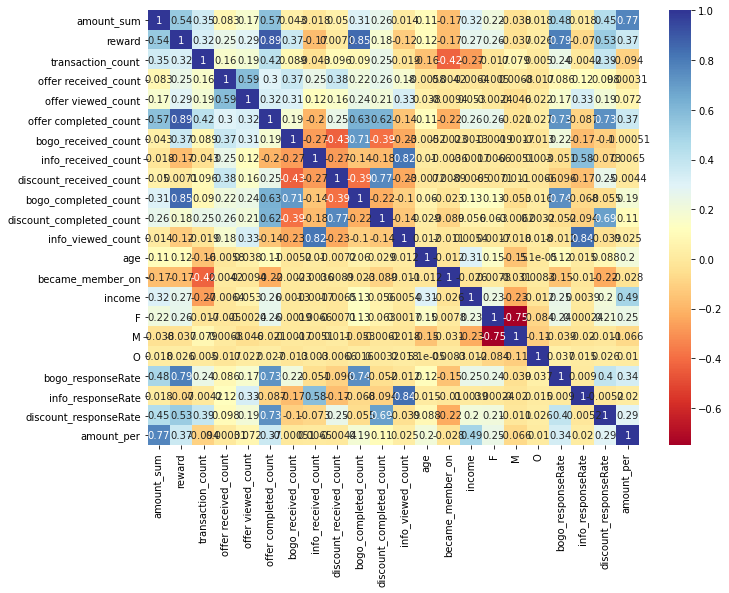

In [64]:
# checking correlation matrix with heatmap

plt.subplots(figsize=(11,8))
# sns.heatmap(user_data['amount','sex','age','income','became_member_on'].corr(), annot=True, cmap="RdYlBu")
sns.heatmap(user_data.corr(), annot=True, cmap="RdYlBu")

plt.show()

## The correlation matrix among all the information for the users who buy without offers

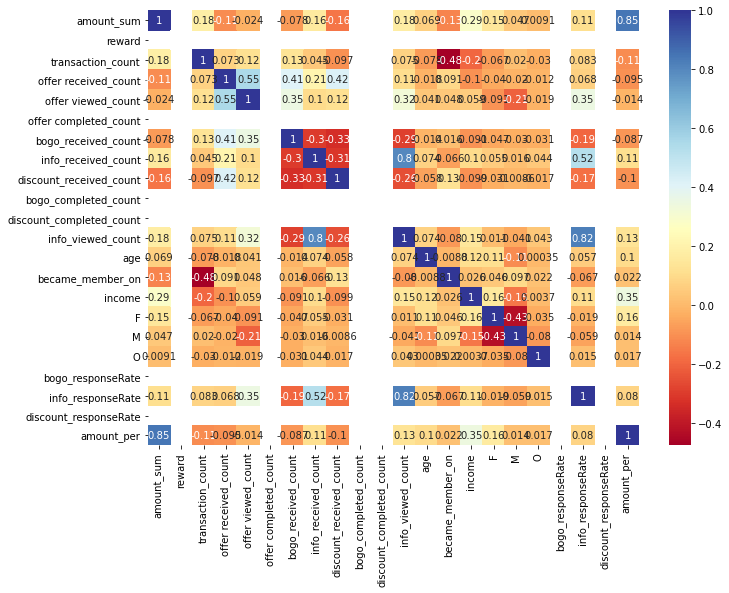

In [65]:
# checking correlation matrix with heatmap

plt.subplots(figsize=(11,8))

sns.heatmap(buy_anyway.corr(), annot=True, cmap="RdYlBu")

plt.show()

## The correlation matrix among all the information for the users who don't buy anything even having offers

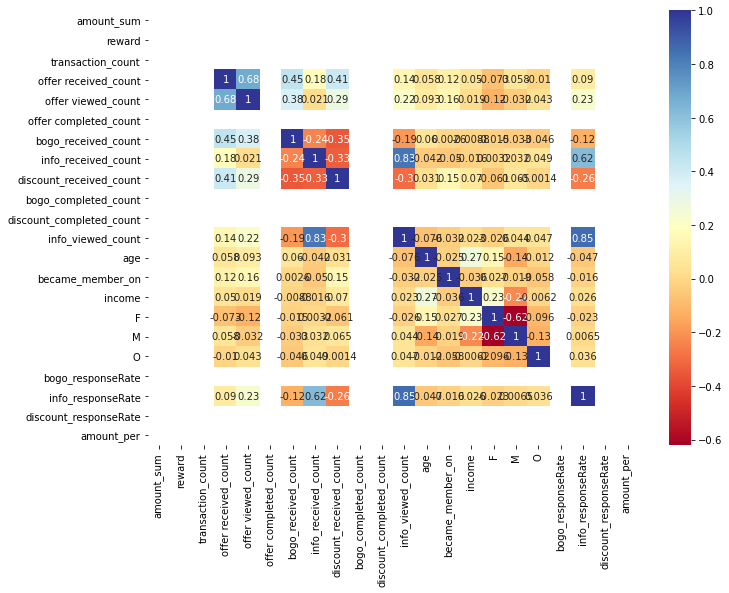

In [66]:
# checking correlation matrix with heatmap

plt.subplots(figsize=(11,8))

sns.heatmap(never_buy.corr(), annot=True, cmap="RdYlBu")

plt.show()

## The correlation matrix among all the information for the users who buy with offers

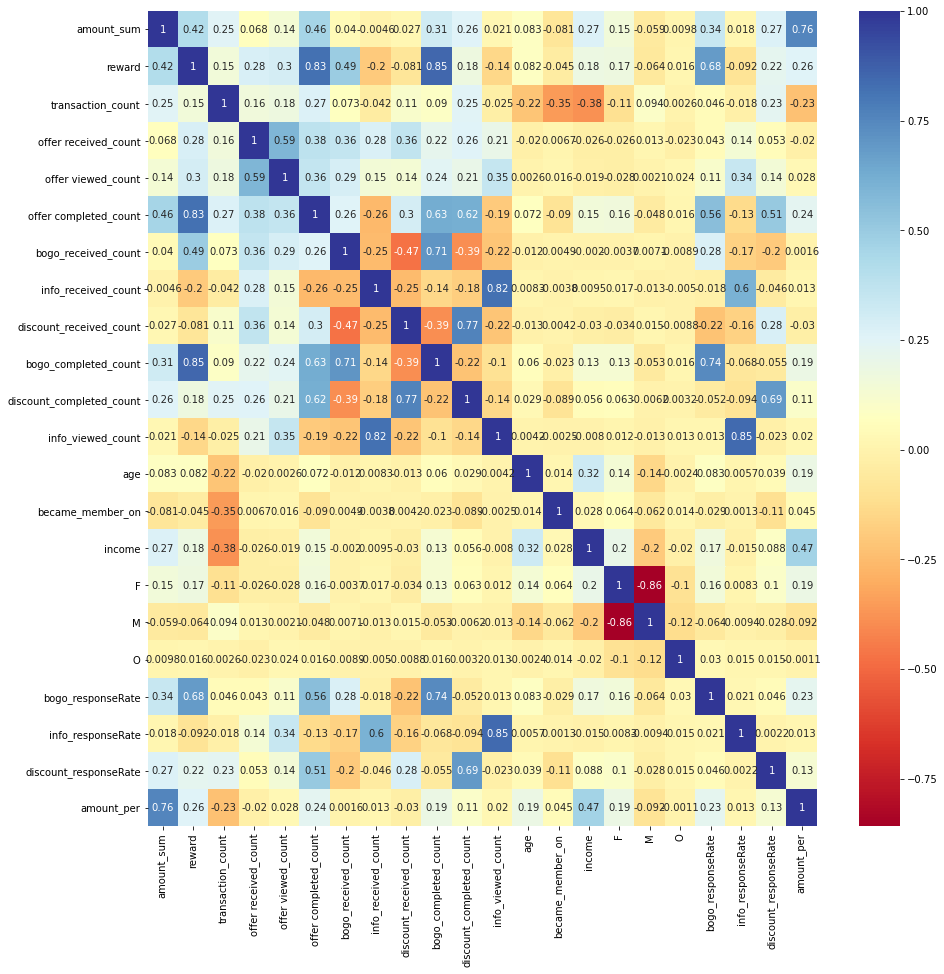

In [67]:
# checking correlation matrix with heatmap

plt.subplots(figsize=(15,15))

sns.heatmap(buy_offer.corr(), annot=True, cmap="RdYlBu")

plt.show()

## 5. Build Models to recommend offers to people who buy with offers

### Use demograph data to predict two different offer response

In [68]:
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score)
import seaborn as sns
import numpy as np

In [69]:
print(list(buy_offer))

['customer_id', 'amount_sum', 'reward', 'transaction_count', 'offer received_count', 'offer viewed_count', 'offer completed_count', 'bogo_received_count', 'info_received_count', 'discount_received_count', 'bogo_completed_count', 'discount_completed_count', 'info_viewed_count', 'gender', 'age', 'became_member_on', 'income', 'F', 'M', 'O', 'bogo_responseRate', 'info_responseRate', 'discount_responseRate', 'amount_per']


In [70]:
# suggest for BOGO/discount
buy_offer['recm_bogo'] = np.where(buy_offer['bogo_responseRate'] > 0, 1, 0)
buy_offer['recm_discount'] = np.where(buy_offer['discount_responseRate'] > 0, 1, 0)


buy_offer_data = buy_offer

buy_offer_data

customer_id  amount_sum  reward  \
0      0009655768c64bdeb2e877511632db8f      127.60     9.0   
2      0011e0d4e6b944f998e987f904e8c1e5       79.46    13.0   
3      0020c2b971eb4e9188eac86d93036a77      196.86    14.0   
4      0020ccbbb6d84e358d3414a3ff76cffd      154.05    13.0   
5      003d66b6608740288d6cc97a6903f4f0       48.34     9.0   
...                                 ...         ...     ...   
16994  fff29fb549084123bd046dbc5ceb4faa      291.47    47.0   
16995  fff3ba4757bd42088c044ca26d73817a      580.98     9.0   
16996  fff7576017104bcc8677a8d63322b5e1       29.94     9.0   
16998  fffad4f4828548d1b5583907f2e9906b       88.83    15.0   
16999  ffff82501cea40309d5fdd7edcca4a07      226.07    18.0   

       transaction_count  offer received_count  offer viewed_count  \
0                    8.0                   5.0                 4.0   
2                    5.0                   5.0                 5.0   
3                    8.0                   5.0                 3.0   
4                   12.0                   4.0                 4.0   
5                   18.0                   5.0                 4.0   
...                  ...                   ...                 ...   
16994               11.0                   6.0                 5.0   
16995               11.0                   6.0                 3.0   
16996                6.0                   5.0                 4.0   
16998               12.0                   4.0                 4.0   
16999               15.0                   6.0                 6.0   

       offer completed_count  bogo_received_count  info_received_count  \
0                        3.0                  1.0                  2.0   
2                        3.0                  1.0                  2.0   
3                        3.0                  2.0                  1.0   
4                        3.0                  2.0                  1.0   
5                        3.0                  0.0                  2.0   
...                      ...                  ...                  ...   
16994                    6.0                  5.0                  0.0   
16995                    3.0                  1.0                  2.0   
16996                    3.0                  3.0                  0.0   
16998                    3.0                  3.0                  1.0   
16999                    6.0                  1.0                  0.0   

       discount_received_count  ...   income    F    M    O  \
0                          2.0  ...  72000.0  0.0  1.0  0.0   
2                          2.0  ...  57000.0  0.0  0.0  1.0   
3                          2.0  ...  90000.0  1.0  0.0  0.0   
4                          1.0  ...  60000.0  1.0  0.0  0.0   
5                          3.0  ...  73000.0  1.0  0.0  0.0   
...                        ...  ...      ...  ...  ...  ...   
16994                      1.0  ...  93000.0  1.0  0.0  0.0   
16995                      3.0  ...  83000.0  1.0  0.0  0.0   
16996                      2.0  ...  73000.0  0.0  1.0  0.0   
16998                      0.0  ...  34000.0  0.0  1.0  0.0   
16999                      5.0  ...  62000.0  1.0  0.0  0.0   

       bogo_responseRate  info_responseRate  discount_responseRate  \
0               1.000000                1.0               1.000000   
2               1.000000                1.0               1.000000   
3               0.500000                1.0               1.000000   
4               1.000000                1.0               1.000000   
5               0.000000                1.0               1.000000   
...                  ...                ...                    ...   
16994           1.000000                0.0               1.000000   
16995           1.000000                0.5               0.666667   
16996           0.333333                0.0               1.000000   
16998           1.000000                1.0               0.000000   
16999         

In [71]:
# removing the missing data
buy_offer_data = buy_offer_data.dropna()

buy_offer_data

customer_id  amount_sum  reward  \
0      0009655768c64bdeb2e877511632db8f      127.60     9.0   
2      0011e0d4e6b944f998e987f904e8c1e5       79.46    13.0   
3      0020c2b971eb4e9188eac86d93036a77      196.86    14.0   
4      0020ccbbb6d84e358d3414a3ff76cffd      154.05    13.0   
5      003d66b6608740288d6cc97a6903f4f0       48.34     9.0   
...                                 ...         ...     ...   
16994  fff29fb549084123bd046dbc5ceb4faa      291.47    47.0   
16995  fff3ba4757bd42088c044ca26d73817a      580.98     9.0   
16996  fff7576017104bcc8677a8d63322b5e1       29.94     9.0   
16998  fffad4f4828548d1b5583907f2e9906b       88.83    15.0   
16999  ffff82501cea40309d5fdd7edcca4a07      226.07    18.0   

       transaction_count  offer received_count  offer viewed_count  \
0                    8.0                   5.0                 4.0   
2                    5.0                   5.0                 5.0   
3                    8.0                   5.0                 3.0   
4                   12.0                   4.0                 4.0   
5                   18.0                   5.0                 4.0   
...                  ...                   ...                 ...   
16994               11.0                   6.0                 5.0   
16995               11.0                   6.0                 3.0   
16996                6.0                   5.0                 4.0   
16998               12.0                   4.0                 4.0   
16999               15.0                   6.0                 6.0   

       offer completed_count  bogo_received_count  info_received_count  \
0                        3.0                  1.0                  2.0   
2                        3.0                  1.0                  2.0   
3                        3.0                  2.0                  1.0   
4                        3.0                  2.0                  1.0   
5                        3.0                  0.0                  2.0   
...                      ...                  ...                  ...   
16994                    6.0                  5.0                  0.0   
16995                    3.0                  1.0                  2.0   
16996                    3.0                  3.0                  0.0   
16998                    3.0                  3.0                  1.0   
16999                    6.0                  1.0                  0.0   

       discount_received_count  ...   income    F    M    O  \
0                          2.0  ...  72000.0  0.0  1.0  0.0   
2                          2.0  ...  57000.0  0.0  0.0  1.0   
3                          2.0  ...  90000.0  1.0  0.0  0.0   
4                          1.0  ...  60000.0  1.0  0.0  0.0   
5                          3.0  ...  73000.0  1.0  0.0  0.0   
...                        ...  ...      ...  ...  ...  ...   
16994                      1.0  ...  93000.0  1.0  0.0  0.0   
16995                      3.0  ...  83000.0  1.0  0.0  0.0   
16996                      2.0  ...  73000.0  0.0  1.0  0.0   
16998                      0.0  ...  34000.0  0.0  1.0  0.0   
16999                      5.0  ...  62000.0  1.0  0.0  0.0   

       bogo_responseRate  info_responseRate  discount_responseRate  \
0               1.000000                1.0               1.000000   
2               1.000000                1.0               1.000000   
3               0.500000                1.0               1.000000   
4               1.000000                1.0               1.000000   
5               0.000000                1.0               1.000000   
...                  ...                ...                    ...   
16994           1.000000                0.0               1.000000   
16995           1.000000                0.5               0.666667   
16996           0.333333                0.0               1.000000   
16998           1.000000                1.0               0.000000   
16999         

### The X, Y used to build model

In [72]:
# decision tree model
# X: age, gender, income, became_member_on
# y1: recommend bogo offer
# y2: recommend discount offer

X = buy_offer_data[['age','F','M','O','became_member_on','income']]
y1 = buy_offer_data["recm_bogo"]
y2 = buy_offer_data["recm_discount"]

X

age    F    M    O  became_member_on   income
0      33.0  0.0  1.0  0.0       2017.391667  72000.0
2      40.0  0.0  0.0  1.0       2018.108333  57000.0
3      59.0  1.0  0.0  0.0       2016.261111  90000.0
4      24.0  1.0  0.0  0.0       2016.947222  60000.0
5      26.0  1.0  0.0  0.0       2017.558333  73000.0
...     ...  ...  ...  ...               ...      ...
16994  59.0  1.0  0.0  0.0       2017.752778  93000.0
16995  69.0  1.0  0.0  0.0       2015.805556  83000.0
16996  71.0  0.0  1.0  0.0       2017.919444  73000.0
16998  34.0  0.0  1.0  0.0       2017.147222  34000.0
16999  45.0  1.0  0.0  0.0       2016.986111  62000.0

[11916 rows x 6 columns]

In [73]:
# Split the data
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X,y1, test_size=0.1)

X2_train, X2_test, y2_train, y2_test = train_test_split(X,y2, test_size=0.1)

### (1) to recommend BOGO offer

Accuracy: 72.90%


<AxesSubplot:>

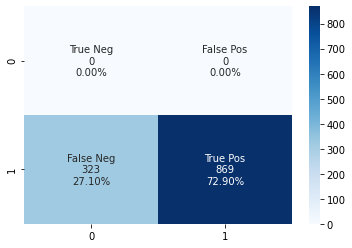

In [75]:
# logistic regression model
# X1: age, gender, income, became_member_on
# y1: bogo

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression()     # L2 regularization is applied by default
clf.fit(X1_train, y1_train)

pred = clf.predict(X1_test)

accuracy = accuracy_score(pred, y1_test)
print("Accuracy:", '{:.2%}'.format(accuracy))

cf_matrix = confusion_matrix(pred, y1_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Blues')

### (2) to recommend discount offer

Accuracy: 80.87%


<AxesSubplot:>

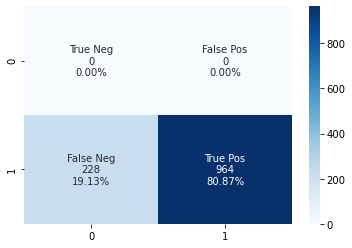

In [78]:
# logistic regression model
# X2: age, gender, income, became_member_on
# y2: discount offer


clf = LogisticRegression()     # L2 regularization is applied by default
clf.fit(X2_train, y2_train)

pred = clf.predict(X2_test)

accuracy = accuracy_score(pred, y2_test)
print("Accuracy:", '{:.2%}'.format(accuracy))

cf_matrix = confusion_matrix(pred, y2_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Blues')